In [1]:
# ref: 

# https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

# http://stronginference.com/pymc3-release.html
# https://docs.pymc.io/notebooks/getting_started.html

# https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

[comp,T,descriptors] vs [strength]

comp = chemical composition of the alloy,
T = temperature at which tension test is carried out,
descriptors = rule of mixture based descriptors + composition based descriptors

strength = strength in MPa

In [1]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
np.random.seed(23)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


[[   6.        0.        0.     ...   17.1288  194.     1965.    ]
 [   6.        0.        0.     ...   17.1288  194.      678.    ]
 [   6.        0.        0.     ...   17.1288  194.      166.    ]
 ...
 [   0.        0.        0.     ...   17.5     194.      834.    ]
 [   0.        0.        0.     ...   17.5     194.      187.    ]
 [   0.        0.        0.     ...   17.5     194.       58.    ]]
(117, 155)
Shuffling (117, 155)
Seperating (117, 154)
Seperating (117, 1)
Splitting (93, 154) (93, 1)
Splitting (24, 154) (24, 1)
Scaling (93, 154) (93, 1)
Scaling (24, 154) (24, 1)
Scaled(train+test) (117, 154) (117, 1)


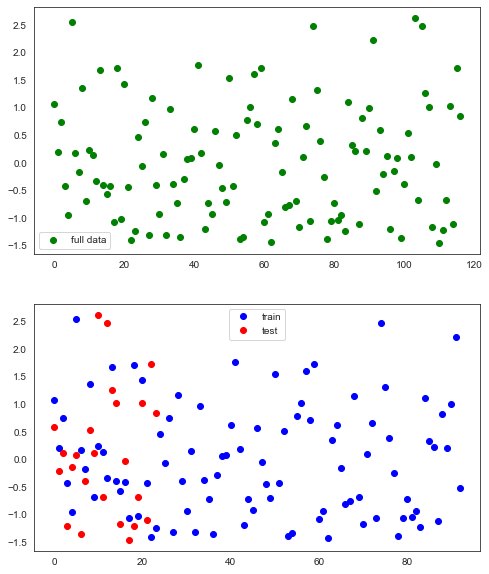

In [2]:
# dataset

import numpy as np
np.random.seed(23)

# 'Strength_data_modified_sharmila.csv' removed all columns (feature vectors) with zero standard deviation.
import pandas as pd
Strength_data = np.array(pd.read_csv('Strength_data_modified_sharmila.csv'))
print(Strength_data)
print(np.shape(Strength_data))

# Step1: Shuffling
from sklearn.utils import shuffle
Strength_data = shuffle(Strength_data,random_state=23)
# print(Strength_data)
print('Shuffling',np.shape(Strength_data))

# Step2: Seperating X_data and y_data
X_data = Strength_data[:,0:np.shape(Strength_data)[1]-1]
print ('Seperating',np.shape(X_data))
# print (X_data)
y_data = Strength_data[:,-1][:,None]
print ('Seperating',np.shape(y_data))
# print (y_data)

# Step3: Splitting train test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=23)
print ('Splitting',np.shape(X_train), np.shape(y_train))
print ('Splitting',np.shape(X_test), np.shape(y_test))

# Step4: Scaling X , Scaling y
# https://towardsdatascience.com/6-amateur-mistakes-ive-made-working-with-train-test-splits-916fabb421bb
# https://sebastianraschka.com/faq/docs/scale-training-test.html
# scale train data and use those means and dev for scaling test data to avoid info leakage
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X_train)
X_train = scaler_X.transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
scaler_y.fit(y_train)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

print ('Scaling',np.shape(X_train), np.shape(y_train))
print ('Scaling',np.shape(X_test), np.shape(y_test))

#combined data
X_data=np.vstack((X_train,X_test))
y_data=np.vstack((y_train,y_test))

print ('Scaled(train+test)',np.shape(X_data),np.shape(y_data))

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.plot(y_data,'go',label='full data')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(y_train,'bo',label='train')
ax2.plot(y_test,'ro',label='test')
ax2.legend()
plt.show()

In [3]:
# Building pymc model

n_hidden = 100

# Initialize random weights between each layer
init_w_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_w_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_w_out = np.random.randn(n_hidden,1).astype(floatX)

init_b_1 = np.random.randn(n_hidden).astype(floatX)
init_b_2 = np.random.randn(n_hidden).astype(floatX)
init_b_out = np.random.randn(1).astype(floatX)


def DNN(x_tensor, weights_in_1, bias_in_1, weights_1_2, bias_1_2, weights_2_out, bias_2_out):
    act_1 = pm.math.sigmoid(pm.math.dot(x_tensor,weights_in_1)+bias_in_1)
    act_2 = pm.math.sigmoid(pm.math.dot(act_1,weights_1_2)+bias_1_2)
    act_out = pm.math.dot(act_2,weights_2_out)+bias_2_out
    return act_out

with pm.Model() as neural_network:
    # Trick: Turning inputs and outputs into shared variables 
    # It's still the same thing, but we can later change the values of the shared variable
    # (to switch in the test-data later) and pymc3 will just use the new data.
    # Kind-of like a pointer we can redirect.
    # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
    y_tensor = theano.shared(y_train)
    x_tensor = theano.shared(X_train)

    #PRIOR
    # Weights and biases from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                             shape=(X_train.shape[1], n_hidden),
                             testval=init_w_1)
    
    bias_in_1 = pm.Normal('b_in_1', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_1)

    # Weights and biases from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                            shape=(n_hidden, n_hidden),
                            testval=init_w_2)
  
    bias_1_2 = pm.Normal('b_1_2', 0, sigma=1,
                             shape=(n_hidden),
                             testval=init_b_2)

    # Weights and biases from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                              shape=(n_hidden,1),
                              testval=init_w_out)

    bias_2_out = pm.Normal('b_2_out', 0, sigma=1,
                             shape=(1),
                             testval=init_b_out)
        
    # Build neural-network using activation function
    act_out = DNN(x_tensor, weights_in_1, bias_in_1, weights_1_2, bias_1_2, weights_2_out, bias_2_out)

    # LIKELIHOOD
    out = pm.Normal('out', mu=act_out, sigma=0.1, observed=y_tensor)


(5, 117)


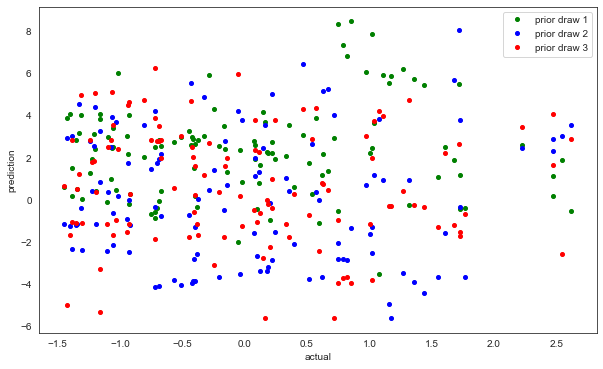

In [7]:
#checking prior draws

with neural_network:
    preds =[DNN(X_data, weights_in_1.random(), bias_in_1.random(), weights_1_2.random(), bias_1_2.random(), weights_2_out.random(), bias_2_out.random()).eval()
     for _ in range(5)]
    preds = np.asarray(preds)
    outputs = preds.reshape(preds.shape[0],preds.shape[1])
    print(np.shape(outputs))

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(y_data,outputs[0].T, 'o', color='green',markersize=4,label='prior draw 1')# full data (train+test)
    ax.plot(y_data,outputs[1].T, 'o', color='blue',markersize=4,label='prior draw 2')# full data (train+test)
    ax.plot(y_data,outputs[2].T, 'o', color='red',markersize=4,label='prior draw 3')# full data (train+test)
    ax.set_xlabel('actual')
    ax.set_ylabel('prediction')
    ax.legend()
    plt.show()

In [8]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [9]:
# Carrying out ADVI

# We use the more_replacements key-word argument to swap-out the original Theano tensors 
# with the batched versions defined above.
map_tensor_batch = {y_tensor: pm.Minibatch(y_train, 32),
                    x_tensor: pm.Minibatch(X_train, 32)}

with neural_network:
#     advi_fit = pm.fit(method=pm.ADVI(), n=100000, #this is a mean-field approximation so we ignore correlations in the posterior.
#                       more_replacements=map_tensor_batch)
    advi_fit = pm.fit(method=pm.ADVI(), n=100000, #this is a mean-field approximation so we ignore correlations in the posterior.
                      more_replacements=map_tensor_batch, obj_optimizer = pm.adam())

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 1,451.8: 100%|██████████| 100000/100000 [07:43<00:00, 215.55it/s]
Finished [100%]: Average Loss = 1,450.7


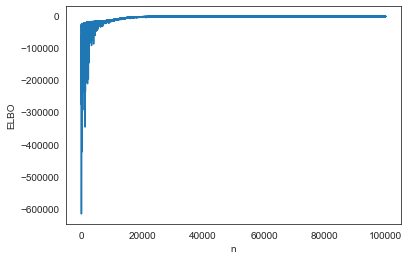

In [10]:
advi_elbo = pd.DataFrame(
    {'ELBO': -(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

## Drawing samples

In [11]:
trace = advi_fit.sample(draws=10000)
# pm.traceplot(trace)
# pm.summary(trace)
# pm.forestplot(trace)

## Checking

(5, 117)


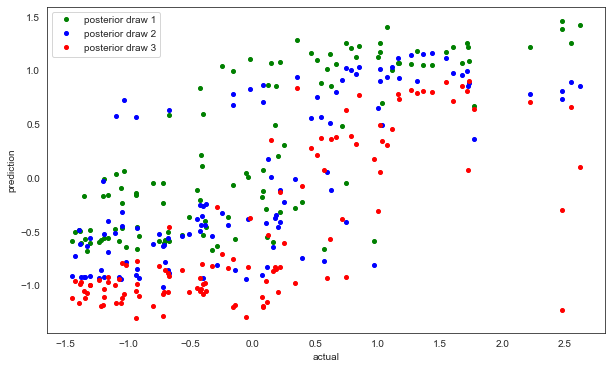

In [12]:
# checking posterior draws

preds =[DNN(X_data, trace['w_in_1'][i], trace['b_in_1'][i], trace['w_1_2'][i], trace['b_1_2'][i], trace['w_2_out'][i], trace['b_2_out'][i]).eval()
 for i in range(5)]
preds = np.asarray(preds)
outputs = preds.reshape(preds.shape[0],preds.shape[1])
print(np.shape(outputs))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(y_data,outputs[0].T, 'o', color='green',markersize=4,label='posterior draw 1')# full data (train+test)
ax.plot(y_data,outputs[1].T, 'o', color='blue',markersize=4,label='posterior draw 2')# full data (train+test)
ax.plot(y_data,outputs[2].T, 'o', color='red',markersize=4,label='posterior draw 3')# full data (train+test)
ax.set_xlabel('actual')
ax.set_ylabel('prediction')
ax.legend()
plt.show()

## Testing

In [13]:
# testing on whole data for now instead of test data
y_tensor.set_value(y_data)
x_tensor.set_value(X_data)

In [14]:
posterior_preds = pm.sample_posterior_predictive(trace, 1000, neural_network)
mean_prediction = np.mean(posterior_preds['out'], axis=0)
stddev_prediction = np.std(posterior_preds['out'], axis=0)
print (posterior_preds['out'].shape)

100%|██████████| 1000/1000 [00:13<00:00, 73.50it/s]

(1000, 117, 1)


         ADVI    actual  error_ADVI
0    0.965673  1.074862   -0.109190
1   -0.313529  0.205412   -0.518941
2    1.147482  0.747540    0.399942
3   -0.473660 -0.422637   -0.051023
4   -0.434498 -0.940216    0.505717
..        ...       ...         ...
112  0.373487 -0.670175    1.043662
113  0.840972  1.033947   -0.192975
114 -0.339497 -1.093648    0.754151
115  1.068993  1.729507   -0.660514
116  1.191626  0.849828    0.341798

[117 rows x 3 columns]


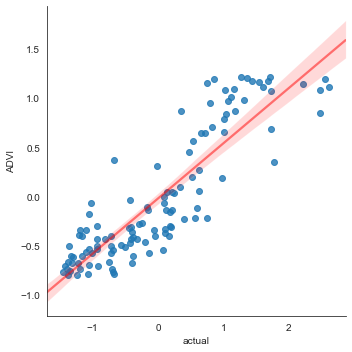

In [15]:
prediction_data = pd.DataFrame(
    {'ADVI': mean_prediction.flatten(), 
     'actual': y_data.flatten(),
     'error_ADVI': ( mean_prediction - y_data).flatten()})

print (prediction_data)

_ = sns.lmplot(y='ADVI', x='actual', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

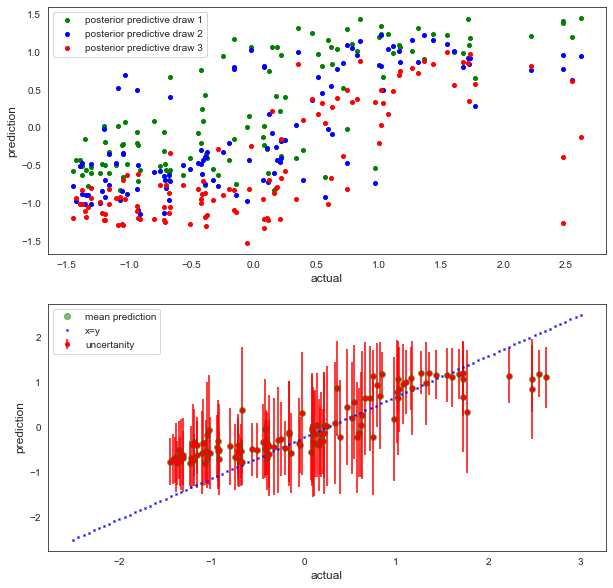

In [20]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(211)
ax1.plot(y_data,posterior_preds['out'][0], 'o', color='green',markersize=4,label='posterior predictive draw 1') # full data (train+test)
ax1.plot(y_data,posterior_preds['out'][1], 'o', color='blue',markersize=4,label='posterior predictive draw 2') # full data (train+test)
ax1.plot(y_data,posterior_preds['out'][2], 'o', color='red',markersize=4,label='posterior predictive draw 3') # full data (train+test)
ax1.set_xlabel('actual',fontsize=12)
ax1.set_ylabel('prediction',fontsize=12)
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(y_data,mean_prediction, 'o', color='green', lw=2, alpha=0.5, label='mean prediction') # full data (train+test)
ax2.errorbar(y_data, mean_prediction, yerr=2*stddev_prediction, fmt='o', label='uncertanity', color='red',markersize=4)
ax2.plot(np.linspace(-2.5,3,100),  np.linspace(-2.5,2.5,100), 'x',label='x=y',  color='blue',markersize=2)
ax2.set_xlabel('actual',fontsize=12)
ax2.set_ylabel('prediction',fontsize=12)
ax2.legend()

plt.show()

In [19]:
RMSE = np.sqrt(np.mean(prediction_data.error_ADVI ** 2))

print(f'RMSE for ADVI predictions = {RMSE:.3f}')

RMSE for ADVI predictions = 0.551
